In [1]:
import math as m
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
%matplotlib inline

### References

The referenced chapters, formulae and problems are from the book [Computational Physics, by Jos Thijssen](https://www.cambridge.org/core/books/computational-physics/BEE73B0139D4A9993193B57CDC62096E#fndtn-information).

This is only introductory material for more advanced topics/code presented on the [Computational Physics Blog](https://compphys.go.ro).

Related with Hartree-Fock I would recommend visiting:
[How to solve a quantum many body problem](https://compphys.go.ro/how-to-solve-a-quantum-many-body-problem/) - on Born-Oppenheimer approximation, diagonalization and variational primciple (on this one you may find several other topics on the blog).

[The Hartree-Fock program](https://compphys.go.ro/the-hartree-fock-program/) - describes a C++ project I have on GitHub: [HartreeFock](https://github.com/aromanro/HartreeFock) which goes way beyond the following simple issues.



### From here, the variational Hydrogen computation, chapter 3

We're starting using Gaussians as basis functions. Here only $\Phi(r)=e^{-\alpha r^2}$. For the more complex ones and the details on the many centers cases, please check out the blog and the C++ Hartree-Fock project.

In [2]:
# 3.26, 4.16
def Gaussian(alpha, r):
    return m.exp(-alpha*r*r)

In [3]:
alpha=(13.00773, 1.962079, 0.444529, 0.1219492) # from 3.27
#alpha=(14, 2, 0.5, 0.1) # try something different here to see how it affects the results

Let's see how they look like:

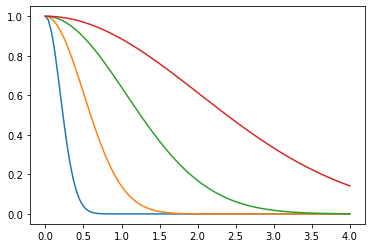

In [4]:
f = np.zeros((100, 4))
r = np.linspace(0, 4, 100)
for i in range(100):
    for j in range(4):
        f[i, j] = Gaussian(alpha[j], r[i])
        
plt.plot(r, f)
plt.show()

Integrals are very simple, the gaussians are centered in the same point (the nucleus), see eqn 3.29:

In [5]:
def Overlap(alpha, ind1, ind2):
    return m.pow(m.pi/(alpha[ind1] + alpha[ind2]), 3./2.)

In [6]:
def Kinetic(alpha, ind1, ind2):
    return 3*alpha[ind1]*alpha[ind2]*m.pow(m.pi, 3./2.)/m.pow(alpha[ind1] + alpha[ind2],5./2.)

In [7]:
def Coulomb(alpha, ind1, ind2):
    return -2 * m.pi / (alpha[ind1] + alpha[ind2])

The basis functions are not orthogonal, so we have to solve the generalized eigenvalue problem, using the overlap:

In [8]:
basisSize = 4

In [9]:
H = np.zeros((basisSize, basisSize))
Ovr = np.zeros((basisSize, basisSize))
for i in range(basisSize):
    H[i, i] = Kinetic(alpha, i, i) + Coulomb(alpha, i, i)
    Ovr[i, i] = Overlap(alpha, i, i)
    for j in range(i):
        H[i, j] = Kinetic(alpha, i, j) + Coulomb(alpha, i, j)
        Ovr[i, j] = Overlap(alpha, i, j)
        H[j, i] = H[i, j]
        Ovr[j, i] = Ovr[i, j]

In [10]:
eigvals, eigvecs = eigh(H, Ovr, eigvals_only=False)

In [11]:
print(eigvals[0])

-0.4992784056674856


The exact result is -0.5 (here we use atomic units, the energy is in Hartrees).

The result here is quite good (you can often do that if you know the exact result in advance). DFTAtom gets -0.445 (that's the expected result for LDA, check out [NIST](https://www.nist.gov/pml/atomic-reference-data-electronic-structure-calculations/atomic-reference-data-electronic-7-0)) and HartreeFock (unrestricted) with STO6G gets -0.471. With the Variational Quantum Monte Carlo project with STO6G I also got -0.471. As the problem is analytically solvable and one knows the result, it's no surprise that the result is so good. One just has to ensure that the space spanned by the basis vectors includes as much as possible of the real solution.

Now let's look at the computed wavefunction together with the exact solution:

In [12]:
def Wavefunction(alpha, eigenvecs, r, ind = 0):
    v = 0.
    for i in range(basisSize):
        v += eigenvecs[i, ind] * Gaussian(alpha[i], r)
    return v

In [13]:
r = np.linspace(0, 2, 100)
w = np.zeros((100, 2))
for i in range(100):
    w[i, 0] = np.abs(Wavefunction(alpha, eigvecs, r[i]))
    w[i, 1] = 1. / np.sqrt(np.pi) * np.exp(-r[i])

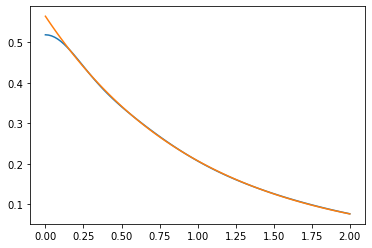

In [14]:
plt.plot(r, w)
plt.show()

### Chap 4, Helium computation

In [15]:
alpha = (0.298073, 1.242567, 5.782948, 38.47497)

In [16]:
# 4.11
def TwoElectronSingleCenter(alpha, p, r, q, s):
    return 2. * m.pow(m.pi, 5. / 2.) / ((alpha[p]+alpha[q])*(alpha[r]+alpha[s])*m.sqrt(alpha[p]+alpha[q]+alpha[r]+alpha[s]))

In [17]:
H = np.zeros((basisSize, basisSize))
Ovr = np.zeros((basisSize, basisSize))
Q = np.zeros((basisSize, basisSize, basisSize, basisSize))

for i in range(basisSize):
    for j in range(basisSize):
        H[i, j] = Kinetic(alpha, i, j) + 2. * Coulomb(alpha, i, j) #the 2 is due of Z=2 for Helium
        Ovr[i, j] = Overlap(alpha, i, j)
        for k in range(basisSize):
            for n in range(basisSize):
                Q[i, j, k, n]=TwoElectronSingleCenter(alpha, i, j, k, n)

In [18]:
v = 1. / m.sqrt(Ovr.sum())

C = np.array([v, v, v, v]) # a choice for C to start with. Check the commented one instead
#C = np.array([1, 1, 1, 1])

In [19]:
F = np.zeros((basisSize, basisSize))
oldE = 100

for cycle in range(100):
    
    # 4.18
    #for i in range(basisSize):
    #    for j in range(basisSize):
    #        F[i, j] = H[i, j]
    #        for k in range(basisSize):
    #            for l in range(basisSize):
    #                F[i, j] += Q[i, k, j, l] * C[k] * C[l]
                    
    F = H + np.einsum('ikjl,k,l', Q, C, C)                    
                    
    # 4.20
    eigvals, eigvecs = eigh(F, Ovr, eigvals_only=False)

    C = eigvecs[:,0]

    # 4.21
    #Eg = 0
    #for i in range(basisSize):
    #    for j in range(basisSize):
    #        Eg += 2 * C[i] * C[j] * H[i, j]
    #        for k in range(basisSize):
    #            for l in range(basisSize):
    #                Eg += Q[i, k, j, l] * C[i] * C[j] * C[k] * C[l]
                    
    Eg = 2 * np.einsum('ij,i,j', H, C, C) + np.einsum('ikjl,i,j,k,l', Q, C, C, C, C)
    
    if abs(oldE-Eg) < 1E-10:
        break
    
    oldE = Eg

In [20]:
print(Eg)

-2.855160382369241


HartreeFock with STO6G gets here -2.846 (but with a basis set with more Gaussians, you certainly can get better results), DFTAtom -2.8348 (again, that's normal for LDA: [NIST](https://www.nist.gov/pml/atomic-reference-data-electronic-structure-calculations/atomic-reference-data-electronic-7-1)) and the Variational Quantum Monte Carlo, -2.8759. The later 'beats' the result obtained here. 

### The first problem, H2+ (problem 4.8)

Now we have two centers so intergrals get more complex. You may simplify some integrals computation by using the already computed overlap, such optimizations are left out from here, they exist in the C++ project. For the H2+, as there is a single electron, we don't need a self-consistency loop.

In [21]:
# see 4.114 and 4.116
def F0(t):
    if t==0:
        return 1.
    p = m.sqrt(t)
    a = 1. / p
    return a * m.sqrt(m.pi) / 2. * m.erf(p)

In [22]:
# 4.98
def Rp(alpha, beta, Ra, Rb):
    return (alpha*Ra + beta*Rb) / (alpha + beta)

In [23]:
# 4.100
def OverlapTwoCenters(alpha, beta, Ra, Rb):
    difR = Ra - Rb
    len2 = difR.dot(difR)
    aplusb = alpha + beta
    ab = alpha * beta / aplusb
    return m.pow(m.pi / aplusb, 3./2.) * m.exp(-ab * len2)

In [24]:
# 4.103
def KineticTwoCenters(alpha, beta, Ra, Rb):
    difR = Ra - Rb
    len2 = difR.dot(difR)
    aplusb = alpha + beta
    ab = alpha * beta / aplusb
    Ovr = m.pow(m.pi/aplusb, 3./2.) * m.exp(-ab * len2) # it's actually the overlap, check the OverlapTwoCenters
    return ab * (3. - 2. * ab * len2) * Ovr #this can be optimized with already computed overlap, see above

In [25]:
# 4.115
def Nuclear(alpha, beta, Ra, Rb, Rc, Z = 1.):
    aplusb = alpha + beta
    ab = alpha * beta / aplusb
    difR = Ra - Rb
    len2 = difR.dot(difR)
    difRc = Rp(alpha, beta, Ra, Rb) - Rc
    len2c = difRc.dot(difRc)
    K = m.exp(-ab*len2)
    return -2. * m.pi * Z / aplusb * K * F0(aplusb*len2c)

In [26]:
# 4.123
def TwoElectronTwoCenter(alpha, beta, gamma, delta, Ra, Rb, Rc, Rd):
    RP = Rp(alpha, gamma, Ra, Rc)
    RQ = Rp(beta, delta, Rb, Rd)
    alphaplusgamma = alpha + gamma
    betaplusdelta = beta + delta
    Rac = Ra - Rc
    Rbd = Rb - Rd
    Rpq = RP - RQ
    Racl2 = Rac.dot(Rac)
    Rbdl2 = Rbd.dot(Rbd)
    Rpql2 = Rpq.dot(Rpq)
    return 2. * m.pow(m.pi, 5./2.) / (alphaplusgamma * betaplusdelta * m.sqrt(alphaplusgamma+betaplusdelta)) * m.exp(-alpha*gamma/alphaplusgamma*Racl2 - beta*delta/betaplusdelta*Rbdl2) * F0(alphaplusgamma*betaplusdelta / (alphaplusgamma+betaplusdelta) * Rpql2)

In [27]:
alpha=(13.00773, 1.962079, 0.444529, 0.1219492)

In [28]:
basisSize = 4 # for each atom

In [29]:
H = np.zeros((basisSize * 2, basisSize * 2))
Ovr = np.zeros((basisSize * 2, basisSize * 2))
R0 = np.array([0, 0, 0])
R1 = np.array([1, 0, 0])
for i in range(basisSize):
    a = alpha[i]    
    basisSizei = basisSize + i
    for j in range(basisSize):        
        b = alpha[j]        
        basisSizej = basisSize + j
        Ovr[i, j] = OverlapTwoCenters(a, b, R0, R0)
        Ovr[basisSizei, j] = OverlapTwoCenters(a, b, R1, R0)
        Ovr[i, basisSizej] = OverlapTwoCenters(a, b, R0, R1)
        Ovr[basisSizei, basisSizej] = OverlapTwoCenters(a, b, R1, R1)
        H[i, j] = KineticTwoCenters(a, b, R0, R0) + Nuclear(a, b, R0, R0, R0) + Nuclear(a, b, R0, R0, R1)
        H[basisSizei, j] = KineticTwoCenters(a, b, R1, R0) + Nuclear(a, b, R1, R0, R0) + Nuclear(a, b, R1, R0, R1)
        H[i, basisSizej] = KineticTwoCenters(a, b, R0, R1) + Nuclear(a, b, R0, R1, R0) + Nuclear(a, b, R0, R1, R1)
        H[basisSizei, basisSizej] = KineticTwoCenters(a, b, R1, R1) + Nuclear(a, b, R1, R1, R0) + Nuclear(a, b, R1, R1, R1)

In [30]:
eigvals, eigvecs = eigh(H, Ovr, eigvals_only=False)

In [31]:
print(eigvals)

[-1.4424553  -0.56337084 -0.38066859 -0.03273059  1.50321097  2.34128796
 20.10200348 20.59185496]


### Now the next problem, for H2 (problem 4.9) - here only the Hartree equation is solved

Filling the Q tensor looks ugly but I think it's better to leave it like that. If you want, you may make it prettier by observing that you can count from 0 to 0xF and use the proper bit to select to pass R0 or R1 and to select the proper sector of the tensor.

In [32]:
Q = np.zeros((basisSize*2, basisSize*2, basisSize*2, basisSize*2))
for i in range(basisSize):
    a = alpha[i]
    basisSizei = basisSize + i
    for j in range(basisSize):
        b = alpha[j]
        basisSizej = basisSize + j
        for k in range(basisSize):
            c = alpha[k]
            basisSizek = basisSize + k
            for n in range(basisSize):
                basisSizel = basisSize + n
                d = alpha[n]                
                Q[i, j, k, n]=TwoElectronTwoCenter(a, b, c, d, R0, R0, R0, R0)
                Q[i, j, k, basisSizel]=TwoElectronTwoCenter(a, b, c, d, R0, R0, R0, R1)
                Q[i, j, basisSizek, n]=TwoElectronTwoCenter(a, b, c, d, R0, R0, R1, R0)
                Q[i, j, basisSizek, basisSizel]=TwoElectronTwoCenter(a, b, c, d, R0, R0, R1, R1)
                Q[i, basisSizej, k, n]=TwoElectronTwoCenter(a, b, c, d, R0, R1, R0, R0)
                Q[i, basisSizej, k, basisSizel]=TwoElectronTwoCenter(a, b, c, d, R0, R1, R0, R1)
                Q[i, basisSizej, basisSizek, n]=TwoElectronTwoCenter(a, b, c, d, R0, R1, R1, R0)
                Q[i, basisSizej, basisSizek, basisSizel]=TwoElectronTwoCenter(a, b, c, d, R0, R1, R1, R1)
                Q[basisSizei, j, k, n]=TwoElectronTwoCenter(a, b, c, d, R1, R0, R0, R0)
                Q[basisSizei, j, k, basisSizel]=TwoElectronTwoCenter(a, b, c, d, R1, R0, R0, R1)
                Q[basisSizei, j, basisSizek, n]=TwoElectronTwoCenter(a, b, c, d, R1, R0, R1, R0)
                Q[basisSizei, j, basisSizek, basisSizel]=TwoElectronTwoCenter(a, b, c, d, R1, R0, R1, R1)
                Q[basisSizei, basisSizej, k, n]=TwoElectronTwoCenter(a, b, c, d, R1, R1, R0, R0)
                Q[basisSizei, basisSizej, k, basisSizel]=TwoElectronTwoCenter(a, b, c, d, R1, R1, R0, R1)
                Q[basisSizei, basisSizej, basisSizek, n]=TwoElectronTwoCenter(a, b, c, d, R1, R1, R1, R0)
                Q[basisSizei, basisSizej, basisSizek, basisSizel]=TwoElectronTwoCenter(a, b, c, d, R1, R1, R1, R1)              

In [33]:
v = 1. / m.sqrt(Ovr.sum())

C = np.array([v, v, v, v, v, v, v, v])

In [34]:
F = np.zeros((2*basisSize, 2*basisSize))
oldE = 100

for cycle in range(100):

    #for i in range(2*basisSize):
    #    for j in range(2*basisSize):
    #        F[i, j] = H[i, j]
    #        for k in range(2*basisSize):
    #            for l in range(2*basisSize):
    #                F[i, j] += Q[i, k, j, l] * C[k] * C[l]
    
    F = H + np.einsum('ikjl,k,l', Q, C, C) 

    eigvals, eigvecs = eigh(F, Ovr, eigvals_only=False)

    C = eigvecs[:,0]

    #Eg = 0
    #for i in range(2*basisSize):
    #    for j in range(2*basisSize):
    #        Eg += 2 * C[i] * C[j] * H[i, j]
    #        for k in range(2*basisSize):
    #            for l in range(2*basisSize):
    #                Eg += Q[i, k, j, l] * C[i] * C[j] * C[k] * C[l]

    Eg = C.dot(H + F).dot(C)
     
    if abs(oldE-Eg) < 1E-10:
        break
    
    oldE = Eg

In [35]:
print(Eg + 1) # +1 for nuclear repulsion energy

-1.0785476087985746


In [36]:
print(C)

[-0.09256159 -0.16517996 -0.12012292 -0.02115447 -0.09256159 -0.16517996
 -0.12012292 -0.02115447]


### Now the next problem, for H2 (problem 4.12) - but now with Hartree-Fock

Here there are a lot of optimizations suggested in the book - for the electron-electron integrals, one can reduce roughly to 1/8 the number of computed integrals using symmetry. Instead of solving the general eigenvalue problem each selfconsistency step you can go with solving only the regular eigenvalue problem, for details please check the book and the C++ HartreeFock project. I didn't want to go with those here.

In [37]:
Qt = np.zeros((basisSize*2, basisSize*2, basisSize*2, basisSize*2))
for p in range(2*basisSize):
    for q in range(2*basisSize):
        for r in range(2*basisSize):
            for s in range(2*basisSize):
                Qt[p, q, r, s] = 2. * Q[p, q, r, s] - Q[p, r, s, q]

In [38]:
C = np.array([v, v, v, v, v, v, v, v]) #reinitialize C

In [39]:
# as above, but Hartree-Fock with Qt instead of Q
F = np.zeros((2*basisSize, 2*basisSize))
oldE = 100

for cycle in range(100):

    #for i in range(2*basisSize):
    #    for j in range(2*basisSize):
    #        F[i, j] = H[i, j]
    #        for k in range(2*basisSize):
    #            for l in range(2*basisSize):
    #                F[i, j] += Qt[i, k, j, l] * C[k] * C[l]
    
    F = H + np.einsum('ikjl,k,l', Q, C, C) 

    eigvals, eigvecs = eigh(F, Ovr, eigvals_only=False)

    C = eigvecs[:,0]
    
    Eg = C.dot(H + F).dot(C)
       
    if abs(oldE-Eg) < 1E-10:
        break
    
    oldE = Eg

In [40]:
print(Eg + 1) # +1 for nuclear repulsion energy

-1.0785476087985746


We obtain the same result as above, despite using Hartree-Fock, because we have only two electrons, one with spin up, one with down, so no spin-exchange.

With the C++ Hartree-Fock project, restricted method with STO6G, the result is -1.0758. Again, with a better basis set the result could be much better. With the Variational Quantum Monte Carlo method I got -1.092, again, better than the result above.

In [41]:
print(C)

[-0.09256159 -0.16517996 -0.12012292 -0.02115447 -0.09256159 -0.16517996
 -0.12012292 -0.02115447]
